In [1]:
! pip install qiskit

     |████████████████████████████████| 6.5 MB 5.2 MB/s 
     |████████████████████████████████| 18.0 MB 324 kB/s 
     |████████████████████████████████| 240 kB 47.6 MB/s 
     |████████████████████████████████| 200 kB 45.3 MB/s 
     |████████████████████████████████| 111 kB 44.1 MB/s 
     |████████████████████████████████| 54 kB 1.6 MB/s 
     |████████████████████████████████| 1.6 MB 45.0 MB/s 
     |████████████████████████████████| 943 kB 50.8 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 3.6 MB 31.2 MB/s 
     |████████████████████████████████| 113 kB 49.1 MB/s 
  Created wheel for qiskit: filename=qiskit-0.36.0-py3-none-any.whl size=11861 sha256=cd4eaa5a2eb273546e378f8ae3b12c6e1d2f53f3f04bddf9d3aebaa6a2648eb8
  Stored in directory: /root/.cache/pip/whee

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy
from tqdm import trange

from qiskit import QuantumCircuit, Aer
from qiskit.quantum_info import Operator
from qiskit.extensions import RXGate, RYGate, RZGate    
from qiskit.quantum_info.states.measures import state_fidelity

In [3]:
def generar_mapa(n1, n3):
    a = 0
    while (np.linalg.matrix_rank(a)!=n1):
        a = n3 * np.random.rand(n1,n1)
        np.fill_diagonal(a,0)
        a = np.tril(a) + np.tril(a, -1).T
    return a

def generar_red(a):
    net1 = nx.from_numpy_matrix(copy.deepcopy(a))
    for e in net1.edges():
        net1[e[0]][e[1]]['color'] = 'black'
    edge_weights_list = [net1[e[0]][e[1]]['weight'] for e in net1.edges()]
    return net1, edge_weights_list

def generar_paquetes(n1,n2):
    moves = np.zeros([n2, 2])    
    rng = np.random.default_rng()
    for i in range(n2):
        moves[i,:] = rng.choice(n1, size=2, replace=False)    
    colores = []
    for i in range(n2):
        color = np.base_repr(np.random.choice(16777215), base=16)
        colores.append('#{:0>6}'.format(color))    
    return moves, colores

def caminos(net1, moves):
    caminitos = []
    i = 0
    for j in range(len(moves)):
        cam = []
        try:
            p = nx.dijkstra_path(net1,int(moves[j,0]),int(moves[j,1]))
            for e in range(len(p)-1):
                cam.append(tuple(sorted((p[e], p[e+1]))))    
        except:
            i += 1
            if i == len(moves):
                return caminitos, True        
        caminitos.append(cam)
    return caminitos, False

def paquetes_en_ruta(camin, ruta, n2):
    lista = []
    for i in range(n2):
        if ruta in camin[i]:
            lista.append(i)
    return lista

def state_out_new_p(x,y,z):
    # all these were calculated with sympy in order to speed computing time
    sqrt_2 = np.sqrt(2)
    cos_x = np.cos(x/2)
    sin_x = np.sin(x/2)
    cos_y = np.cos(y/2)
    sin_y = np.sin(y/2)
    exp_z = np.exp(1j*z)
    exp_m = np.exp(-1j*z)

    s_0 = sqrt_2/2*(-sqrt_2/2*1j*exp_z*sin_y**2 + sqrt_2/2*exp_m*cos_y**2)*cos_x**2 - sqrt_2/2*(-sqrt_2/2*1j*exp_z*cos_y**2 + sqrt_2/2*exp_m*sin_y**2)*sin_x**2 - sqrt_2*1j*(-sqrt_2/2*1j*exp_z*sin_y*cos_y - sqrt_2/2*exp_m*sin_y*cos_y)*sin_x*cos_x + sqrt_2/2*1j*(-(-sqrt_2/2*1j*exp_z*sin_y**2 + sqrt_2/2*exp_m*cos_y**2)*sin_x**2 + (-sqrt_2/2*1j*exp_z*cos_y**2 + sqrt_2/2*exp_m*sin_y**2)*cos_x**2 - 2*1j*(-sqrt_2/2*1j*exp_z*sin_y*cos_y - sqrt_2/2*exp_m*sin_y*cos_y)*sin_x*cos_x)
    s_1 = -sqrt_2/2*1j*(sqrt_2/2*1j*sin_y**2 + sqrt_2/2*cos_y**2)*sin_x*cos_x - sqrt_2/2*(-sqrt_2/2*sin_y*cos_y + sqrt_2/2*1j*sin_y*cos_y)*sin_x**2 + sqrt_2/2*(sqrt_2/2*sin_y*cos_y - sqrt_2/2*1j*sin_y*cos_y)*cos_x**2 - sqrt_2/2*1j*(-sqrt_2/2*sin_y**2 - sqrt_2/2*1j*cos_y**2)*sin_x*cos_x + sqrt_2/2*1j*(-1j*(sqrt_2/2*1j*sin_y**2 + sqrt_2/2*cos_y**2)*sin_x*cos_x + (-sqrt_2/2*sin_y*cos_y + sqrt_2/2*1j*sin_y*cos_y)*cos_x**2 - (sqrt_2/2*sin_y*cos_y - sqrt_2/2*1j*sin_y*cos_y)*sin_x**2 - 1j*(-sqrt_2/2*sin_y**2 - sqrt_2/2*1j*cos_y**2)*sin_x*cos_x)
    s_2 = -sqrt_2/2*1j*(sqrt_2/2*1j*sin_y**2 + sqrt_2/2*cos_y**2)*sin_x*cos_x - sqrt_2/2*(-sqrt_2/2*sin_y*cos_y + sqrt_2/2*1j*sin_y*cos_y)*sin_x**2 + sqrt_2/2*(sqrt_2/2*sin_y*cos_y - sqrt_2/2*1j*sin_y*cos_y)*cos_x**2 - sqrt_2/2*1j*(-sqrt_2/2*sin_y**2 - sqrt_2/2*1j*cos_y**2)*sin_x*cos_x + sqrt_2/2*1j*(-1j*(sqrt_2/2*1j*sin_y**2 + sqrt_2/2*cos_y**2)*sin_x*cos_x + (-sqrt_2/2*sin_y*cos_y + sqrt_2/2*1j*sin_y*cos_y)*cos_x**2 - (sqrt_2/2*sin_y*cos_y - sqrt_2/2*1j*sin_y*cos_y)*sin_x**2 - 1j*(-sqrt_2/2*sin_y**2 - sqrt_2/2*1j*cos_y**2)*sin_x*cos_x)
    s_3 = sqrt_2/2*(sqrt_2/2*exp_z*sin_y**2 - sqrt_2/2*1j*exp_m*cos_y**2)*cos_x**2 - sqrt_2/2*(sqrt_2/2*exp_z*cos_y**2 - sqrt_2/2*1j*exp_m*sin_y**2)*sin_x**2 - sqrt_2*1j*(sqrt_2/2*exp_z*sin_y*cos_y + sqrt_2/2*1j*exp_m*sin_y*cos_y)*sin_x*cos_x + sqrt_2/2*1j*(-(sqrt_2/2*exp_z*sin_y**2 - sqrt_2/2*1j*exp_m*cos_y**2)*sin_x**2 + (sqrt_2/2*exp_z*cos_y**2 - sqrt_2/2*1j*exp_m*sin_y**2)*cos_x**2 - 2*1j*(sqrt_2/2*exp_z*sin_y*cos_y + sqrt_2/2*1j*exp_m*sin_y*cos_y)*sin_x*cos_x)
    p_new = np.round(np.array([s_0, s_1, s_2, s_3]).reshape(1,4),5)
    p_new = np.abs(p_new)**2
    return (p_new)/(np.sum(p_new))

def state_out_new(n, tipo):
    if n==1:
        a = {'1': 1}
        return a
    elif n == 2:
        a0 = {'00': 1}
        a1 = {'01': 1}
        a2 = {'10': 1}
        a3 = {'11': 1}
        x = [a0, a1, a2, a3]
        p_new = state_out_new_p(tipo[0], tipo[1], tipo[2])[0]
        return np.random.choice(x, p = [p_new[0], p_new[1], p_new[2], p_new[3]])

def juego(lista, tipo):
    m = len(lista)
    if m > 0:
        for r in range(int(np.ceil(np.log2(m)))):
            ganadores = []            
            for j in range(int(np.ceil(m/2))):
                jug = 2 - int(m == j+int(np.ceil(m/2)))                        
                measurement = state_out_new(jug, tipo)
                for k,i in enumerate(list(measurement.keys())[0]):
                    if i=='1':
                        ganadores.append(lista[2*j + k])                    
            lista = ganadores   
            m = len(lista)         
    return lista

def output_state(dx,dy,dz):
    I = np.array([[1, 0],
                [0, 1]])
    X = np.array([[0, 1],
                [1, 0]])    
    I_f = np.kron(I, I)
    X_f = np.kron(X, X)
    J = Operator(1 / np.sqrt(2) * (I_f + 1j * X_f))    
    J_dg = J.adjoint()
    circ = QuantumCircuit(2,2)
    circ.append(J, range(2))
    for q in range(2):
        circ.append(RXGate(dx),[q])
        circ.append(RYGate(dy),[q])
        circ.append(RZGate(dz),[q])    
    circ.append(J_dg, range(2))
    backend = Aer.get_backend('statevector_simulator')
    job = backend.run(circ)
    result = job.result()
    outputstate = result.get_statevector(circ, decimals=5)
    return outputstate

def checkear_nozero(rx,ry,rz):
    outputstate = output_state(rx,ry,rz)
    target_state = [0, np.sqrt(2)/2, np.sqrt(2)/2, 0]
    fidelity = state_fidelity(outputstate, target_state)
    return (np.abs(outputstate[0]) > 0.99), fidelity

def reward_qnet(rx, ry, rz, n3, tests):    

    zero_check, fidelity = checkear_nozero(rx,ry,rz)
    if  zero_check == 1:
        return [-200, fidelity]

    n1 = 10                                       # cantidad de ciudades
    n2 = 100                                      # cantidad de paquetes
    p1 = [rx, ry, rz, 1]

    t_routing = 0
    t_traveling = 0

    for p in range(tests):
      a = generar_mapa(n1, n3)                      # genero matriz
      net1, edge_weights_list = generar_red(a)      # genero red
      net2, edge_weights_list = generar_red(a)      # genero copia de red
      moves, colores = generar_paquetes(n1,n2)      # genero paquetes
      caminitos, flag = caminos(net1, moves)        # caminos óptimos
      all_edges2 = [e for e in net2.edges]
      veces = np.zeros(len(all_edges2))

      i = 0
      t1 = 0
      tiemp = 0
      envio = 0

      while not flag:
          t1 += 1
          all_edges = [e for e in net1.edges]
          paquetes_ruta = paquetes_en_ruta(caminitos, all_edges[i], n2)
          if paquetes_ruta == []:
              t1 -= 1  
              i += 1
          else:
              i = 0
              ganadores = juego(paquetes_ruta, p1)
              for x in range(len(ganadores)):
                  moves[ganadores[x]] = [-1,-2]
                  for y in caminitos[ganadores[x]]:
                      veces[np.where((np.array(all_edges2) == y).all(axis=1))[0][0]] += 1
                      tiemp += (2 * veces[np.where((np.array(all_edges2) == y).all(axis=1))[0][0]] - 1) * net2[y[0]][y[1]]['weight']
                      net1.remove_edges_from([y])
                      net2[y[0]][y[1]]['color'] = colores[envio]
                  envio += 1
              caminitos, flag = caminos(net1, moves)
      try:
          temp = tiemp/envio    #tiempo de envío por paquete 
      except ZeroDivisionError:
          temp = 2*n3  

      t_routing += t1  
      t_traveling += temp

    t_total = (t_routing + t_traveling) / tests
    return [-t_total, fidelity]

In [4]:
time = 1000
runs = 1
n3 = [[14],
      [0, time],
      [37.4592]]
prf = np.zeros((time))
flt = np.zeros((time))

tipo = 0
for t in trange(time):
  if t >= n3[1][tipo+1]:
      tipo += 1     
  rotat = np.random.uniform(0,2*np.pi,3)   
  output = np.array(output_state(rotat[0], rotat[1], rotat[2]))
  [rwd, flt[t]] = reward_qnet(rotat[0],rotat[1],rotat[2], n3[0][tipo], runs)
  prf[t] = -n3[2][tipo] / rwd

100%|██████████| 1000/1000 [05:00<00:00,  3.32it/s]


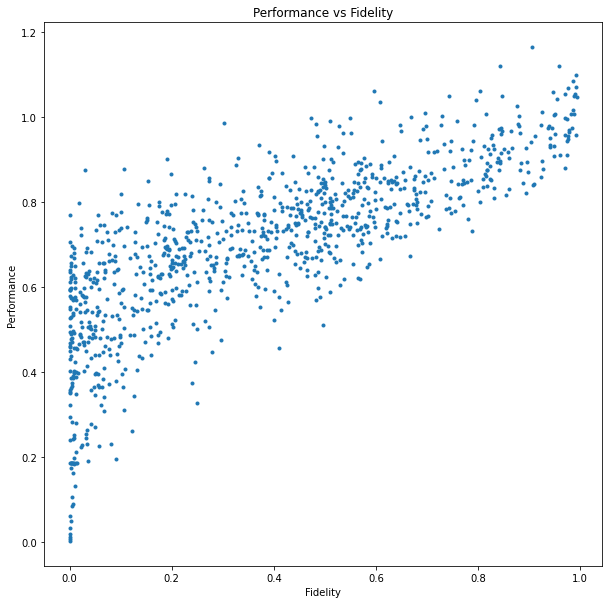

In [5]:
fig = plt.figure(figsize=(10,10))
plt.title("Performance vs Fidelity")
plt.xlabel("Fidelity")
plt.ylabel("Performance")
plt.plot(flt,prf,'.')
plt.show()

In [19]:
# https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/

from numpy import cov
from scipy.stats import pearsonr
from scipy.stats import spearmanr

covariance = cov(flt,prf)
# cov(X, Y) = (sum (x - mean(X)) * (y - mean(Y)) ) * 1/(n-1)
print("Covariance = {}".format(covariance[0][1]))

pearsons = pearsonr(flt,prf)
# pearsonr = covariance(X, Y) / (stdv(X) * stdv(Y))
print("Pearson’s Correlation = {}".format(pearsons[0]))

spearmans = spearmanr(flt,prf)
# spearmanr = covariance(rank(X), rank(Y)) / (stdv(rank(X)) * stdv(rank(Y)))
print("Spearman’s Correlation = {}".format(spearmans[0]))

Covariance = 0.042969754705085496
Pearson’s Correlation = 0.7779713855710788
Spearman’s Correlation = 0.8208677742306358
